In [2]:
# IMPORTING PACKAGES
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import numpy as np
import sklearn.metrics

In [ ]:
# =========IGNORE============
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# DATA DIR - change as per convenience
data_dir = "/content/drive/Shareddrives/IIT-DH _KLE-BGM/Model_1/SN/10x"
batch_size=8
# img_height = 1080
# img_width = 1080
img_size=(224,224)

In [5]:
# IMPORTING AND CREATING DATASETS FOR MODEL
# TRAIN:VALIDATION RATIO = 4:1
train=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode="int",
    validation_split=0.2,
    subset='training',
    seed=123,
#     shuffle=False,
    image_size=img_size,
    batch_size=batch_size
)
validation=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode="int",
    validation_split=0.2,
    subset='validation',
#     shuffle=False,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 217 files belonging to 2 classes.
Using 174 files for training.
Found 217 files belonging to 2 classes.
Using 43 files for validation.


In [6]:
# CLASSES OF DATA
# malignant(1) benign(0)
class_names=train.class_names
print(class_names)

['0', '1']


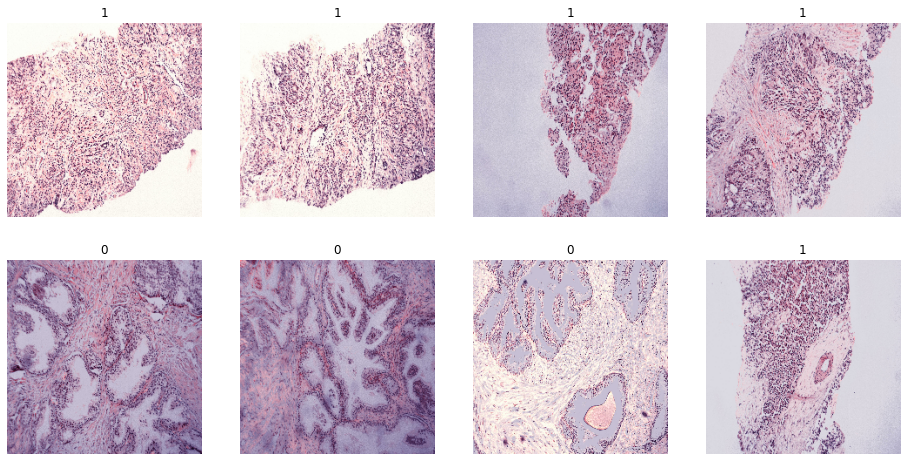

In [7]:
# VISUALISING SOME TRAINING IMAGES
plt.figure(figsize=(16,8))
for images,labels in train.take(1):
    for i in range(8):
        ax=plt.subplot(2,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

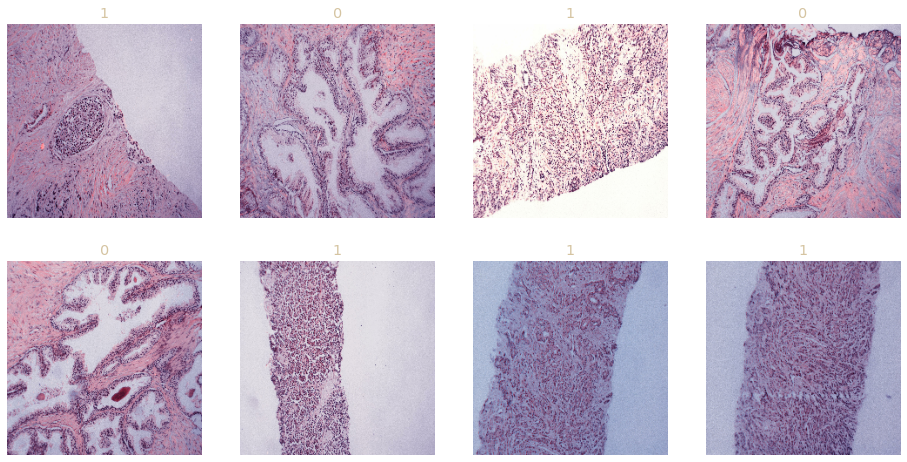

In [ ]:
# VISUALISING SOME VALIDATION IMAGES
plt.figure(figsize=(16,8))
for images,labels in validation.take(1):
    for i in range(8):
        ax=plt.subplot(2,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [8]:
# PREPROCESSING FOR BETTER PERFORMANCE
Autotune=tf.data.experimental.AUTOTUNE
train=train.prefetch(buffer_size=Autotune)

In [9]:
# DATA AUGMENTATION
data_aug=tf.keras.Sequential([
    tfl.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tfl.experimental.preprocessing.RandomRotation((-0.05,0.05)) 
])

In [ ]:
# VISUALISE DATA AUG
# for image,_ in train.take(1):
#     plt.figure(figsize=(10,10))
#     first_img=image[0]
#     for i in range(16):
#         ax=plt.subplot(4,4,i+1)
#         aug_img=data_aug(tf.expand_dims(first_img,0))
#         plt.imshow(aug_img[0]/255)
#         plt.axis("off")
# plt.show()

In [10]:
# IMPORTING MOBILENET V2 AND TUNING FOR DATA
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input
input_shape=img_size+(3,)
# print(input_shape)
base_model=tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable=False

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
# MODEL
inputs=tf.keras.Input(shape=input_shape)
x=data_aug(inputs)
x=preprocess_input(x)
# x=preprocess_input(inputs)
x=base_model(x,training=False)
x=tfl.GlobalAveragePooling2D()(x)
x=tfl.BatchNormalization()(x)
x=tfl.Dropout(0.2)(x)
x=tfl.Dense(512,activation='relu')(x)
x=tfl.BatchNormalization()(x)
x==tfl.Dropout(0.2)(x)
x=tfl.Dense(256,activation='relu')(x)
x=tfl.BatchNormalization()(x)
x=tfl.Dense(128,activation='linear')(x)
x=tfl.Dropout(0.2)(x)
outputs=tfl.Dense(1,activation='sigmoid')(x)

model=tf.keras.Model(inputs,outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120  

In [13]:
# TUNING MODEL PARAMETERS, LOSS FNS AND METRICS
l_r=0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
             metrics=[tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
# TRAINING ON DATA
epochs=50
history=model.fit(train,validation_data=validation,epochs=epochs)

Epoch 1/50
22/22 [==============================] - 38s 1s/step - loss: 0.8857 - precision: 0.7209 - accuracy: 0.5690 - val_loss: 0.6274 - val_precision: 0.8462 - val_accuracy: 0.6744
Epoch 2/50
22/22 [==============================] - 12s 486ms/step - loss: 0.7597 - precision: 0.7667 - accuracy: 0.6264 - val_loss: 0.5553 - val_precision: 0.9167 - val_accuracy: 0.7209
Epoch 3/50
22/22 [==============================] - 12s 485ms/step - loss: 0.6577 - precision: 0.8228 - accuracy: 0.6437 - val_loss: 0.4830 - val_precision: 1.0000 - val_accuracy: 0.8140
Epoch 4/50
22/22 [==============================] - 12s 491ms/step - loss: 0.4601 - precision: 0.8925 - accuracy: 0.7701 - val_loss: 0.4217 - val_precision: 1.0000 - val_accuracy: 0.9070
Epoch 5/50
22/22 [==============================] - 12s 492ms/step - loss: 0.4907 - precision: 0.9205 - accuracy: 0.7759 - val_loss: 0.3731 - val_precision: 1.0000 - val_accuracy: 0.9302
Epoch 6/50
22/22 [==============================] - 12s 485ms/step -

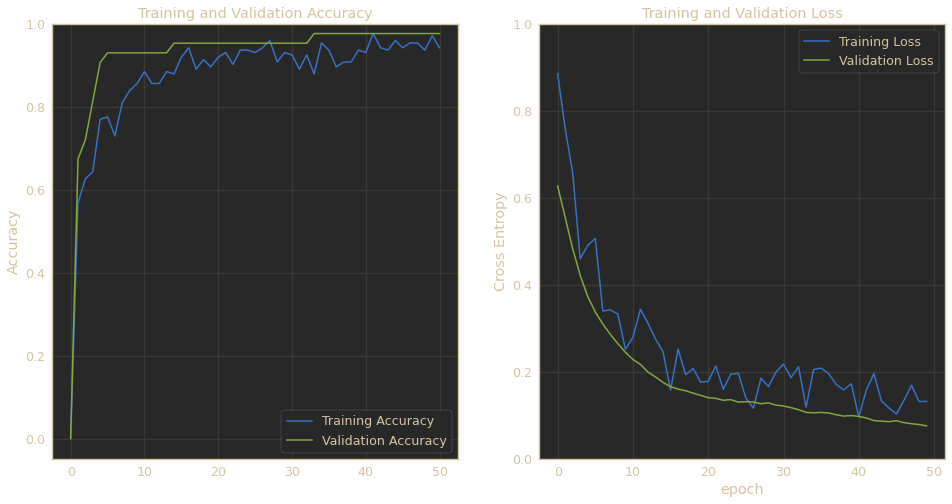

In [ ]:
# VISUALISING ACCURACY AND LOSS VS ITERATIONS
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# DATA FOR EVALUATING MODEL
data=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode="int",
    validation_split=0,
#     subset='training',
    shuffle = False,
    image_size=img_size,
    batch_size=batch_size
)

Found 217 files belonging to 2 classes.


In [ ]:
# TRUE LABEL AND PREDICTED LABEL
data_label = np.concatenate([data_label for _, data_label in data], axis=0)
data_pred = model.predict(data).flatten()
# print(data_label)
# print((data_pred>=0.5).astype(int))

In [ ]:
# METRICS CALCULATION
print(sklearn.metrics.classification_report(data_label,data_pred>=0.5))
print(sklearn.metrics.confusion_matrix(data_label,data_pred>=0.5,labels=[1,0]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.99      1.00       145

    accuracy                           1.00       217
   macro avg       0.99      1.00      0.99       217
weighted avg       1.00      1.00      1.00       217

[[144   1]
 [  0  72]]
